In [19]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from jax import nn, random, lax, vmap, ops
from time import time_ns

from scipy.special import binom

from opt_einsum import contract, contract_expression

import sys
import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

def einsum(equation, *args):
    return contract(equation, *args, backend='jax')

sns.set(context='talk', style='white', color_codes=True, font_scale=.75)

In [2]:
from scipy import io
# load experiment and generate observations
data = io.loadmat('main/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

runs = 1

outcomes1 = jnp.concatenate([(Oreg[:, None].repeat(runs, -2) + 1)//2, 
                            (Oirr[:, None].repeat(runs, -2) + 1)//2], -2)
outcomes2 = jnp.concatenate([Sreg[:, None].repeat(runs, -1) + 2, 
                             Sirr[:, None].repeat(runs, -1) + 2], -1)[..., None]

outcomes = jnp.concatenate([outcomes1, outcomes2], -1)

subs = jnp.array(range(2 * runs))
def process(t, responses):
    return outcomes[t, subs, responses]

# Negative binomial distribution as a discrete phase-type distribution

In [3]:
vdiag = vmap(lambda v: jnp.diag(v, k=0))
voffd = vmap(lambda v: jnp.diag(v, k=1))

n = 10
nu = jnp.arange(1, n + 1)
mu = jnp.arange(4., 45., 1)
p = mu[..., None]/(nu[None] + mu[..., None])

j = jnp.tril(jnp.arange(1, n + 1)[None].repeat(n, 0))
bnm = binom(nu[..., None], jnp.tril(j-1))
p1 = p[..., None] ** jnp.tril((nu[..., None] - j + 1))
p2 = (1 - p[..., None])**jnp.tril(j - 1)
pi =  jnp.tril(bnm * p1 * p2)
pi = jnp.concatenate([pi, 1 - pi.sum(-1, keepdims=True)], -1)

# phase transition matrix for different models m, f_t| f_{t+1}
p_ff = []
for i in range(n):
    vp = p[..., i:i + 1].repeat(i + 1, -1)
    tmp = jnp.concatenate([vdiag(vp) + voffd(1 - vp[..., :-1]), jnp.zeros((p.shape[0], i + 1, n - i - 1))], -1)
    tmp = jnp.concatenate([tmp, 1 - tmp.sum(-1, keepdims=True)], -1)
    tmp = jnp.concatenate([tmp, jnp.ones((p.shape[0], n - i - 1, n + 1))/(n + 1)], -2)
    tmp = jnp.concatenate([tmp, pi[:, i:i+1]], -2)
    p_ff.append(tmp)

p_mff = jnp.stack(p_ff, -3).reshape(-1, n + 1, n + 1)

def nb_dist(mu, nu, d_max):
    d = jnp.expand_dims(jnp.arange(1., d_max + 1.), -1)[..., None]
    k = d - 1.
    p = mu / (nu + mu)
    
    return binom(k + nu - 1, k) * (1 - p)**nu * p ** k

d_max = 50
dist = nb_dist(mu[:, None], nu[None], d_max)

# state transition matrix f_t, j_t| j_{t+1}
p_fjj = jnp.zeros((n+1, 2, 2))
p_fjj = ops.index_add(p_fjj, ops.index[-1, :, 1], 1.)
p_fjj = ops.index_add(p_fjj, ops.index[:-1, :, 0], 1.)

# state transition matrix j_t, c_t | c_{t+1}
p_jcc = jnp.stack([jnp.eye(2), (jnp.ones((2, 2)) - jnp.eye(2))], 0)
p_fcc = einsum('jcz,fj->fcz', p_jcc, p_fjj[:, 0])

In [4]:
# parametric learning and inference
def par_learning(observations, responses, prior):
    p_cfm, params = prior
    obs = jnp.eye(4)[observations]
    
    p_naco = params/params.sum(-1, keepdims=True)
    
    p_c = einsum('nco,no->nc', p_naco[jnp.arange(len(responses)), responses], obs)
    
    post = einsum('nc,ncfm->ncfm', p_c, p_cfm)
    norm = post.reshape(post.shape[:-3] + (-1,)).sum(-1)[..., None, None, None]
    post = post/norm
    
    resp = jnp.eye(3)[responses]
    post_c = post.reshape(post.shape[:-2] + (-1,)).sum(-1)
    
    params_new = params + einsum('na,nc,no->naco', resp, post_c, obs)
    pred = einsum('fcz,mfg,ncfm->nzgm', p_fcc, p_mff, post)
    
    return (pred, params_new)

In [5]:
from jax.scipy.special import digamma
# action selection
def log(x):
    return jnp.nan_to_num(jnp.log(x))

def par_efe(p_c, params, omega, U):
    p_aco = params/params.sum(-1, keepdims=True)
    q_ao = einsum('naco,nc->nao', p_aco, p_c)
    
    KL_a =  - omega * jnp.sum(q_ao * U, -1) + jnp.sum(q_ao * log(q_ao), -1)
    
    H_ac = - (p_aco * digamma(params)).sum(-1) + digamma(params.sum(-1) + 1)
    H_a = einsum('nc,nac->na', p_c, H_ac)
    
    return KL_a + H_a

def par_efe_selection(rng_key, beliefs, gamma=1e3, omega=1., U=jnp.array([-1., 1., 0., 0.])):
    p_cfm, params = beliefs
    
    # expected surprisal based action selection
    p_c = einsum('ncfm->nc', p_cfm)
    
    S_a = par_efe(p_c, params, omega, U)
    
    logits = - gamma * ( S_a - S_a.min(-1, keepdims=True))
    
    # sample choices
    return random.categorical(rng_key, logits)

In [6]:
# implement simulator for POMDP
def simulator(process, learning, selection, prior, seed=0, **model_kw):
    def sim_fn(carry, t):
        rng_key, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = selection(_rng_key, prior, **model_kw)
        
        outcomes = process(t, choices)
        
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, posterior), {'outcomes': outcomes, 
                                      'choices': choices,
                                      'beliefs': prior}
    
    rng_key = random.PRNGKey(seed)
    _, sequence = lax.scan(sim_fn, (rng_key, prior), jnp.arange(len(outcomes)))
    sequence['outcomes'].block_until_ready()
    
    return sequence

In [7]:
prior_mf = p_mff[:, -1]
M = prior_mf.shape[0]
prior_m = jnp.ones(M)/M
prior_fm = (prior_mf * prior_m[:, None]).T
prior_c = jnp.ones(2)/2

pars = jnp.array([
    [[4., 14., 1, 1], [14., 4., 1, 1]],
    [[14., 4., 1, 1], [4., 14., 1, 1]],
    [[1, 1, 1000., 1], [1, 1, 1, 1000.]]
])[None].repeat(outcomes.shape[-2], 0)
probs = einsum('c,fm->cfm', prior_c, prior_fm)[None].repeat(outcomes.shape[-2], 0)
prior = (probs, pars)

In [15]:
for omega in [.25, .5, .75, 1., 1.25, 1.5, 1.75, 2.]:
    sequence = simulator(process, par_learning, par_efe_selection, prior, omega=omega)
    corr = outcomes[..., -1] - 2 == sequence['choices']
    expl = jnp.sum(sequence['choices'] == 2, 0)/1000
    print(omega, corr[400:800].mean(0), expl/(1 - expl))

0.25 [0. 0.] [inf inf]
0.5 [0.7625 0.4625] [0.4450867 1.0408163]
0.75 [0.8275 0.725 ] [0.2642225  0.29701686]
1.0 [0.8425 0.7325] [0.18764846 0.25156444]
1.25 [0.8425 0.7475] [0.14942528 0.20481928]
1.5 [0.845 0.75 ] [0.13250282 0.18063754]
1.75 [0.85   0.7775] [0.12233445 0.14810562]
2.0 [0.8525 0.7875] [0.11358574 0.1299435 ]


In [16]:
for omega in [.75, .8, .85, .9, .95, 1., 1.05, 1.1, 1.15, 1.2]:
    sequence = simulator(process, par_learning, par_efe_selection, prior, omega=omega, U=jnp.array([-1., 1., -.5, -.5]))
    corr = outcomes[..., -1] - 2 == sequence['choices']
    expl = jnp.sum(sequence['choices'] == 2, 0)/1000
    print(omega, corr[400:800].mean(0), expl/(1 - expl))

0.75 [0.8625 0.805 ] [0.09649123 0.10741971]
0.8 [0.87   0.8175] [0.08932462 0.09051254]
0.85 [0.8775 0.82  ] [0.07411385 0.08695652]
0.9 [0.8825 0.8125] [0.06044539 0.07526882]
0.95 [0.895  0.8075] [0.04166667 0.06157112]
1.0 [0.905  0.8225] [0.02040816 0.04384134]
1.05 [0.905 0.84 ] [0.01214575 0.03950104]
1.1 [0.9025 0.8275] [0.00401606 0.01832994]
1.15 [0.905 0.845] [0.00401606 0.02774923]
1.2 [0.905 0.835] [0.001001   0.01832994]


In [17]:
for omega in [.25, .5, .75, 1., 1.25, 1.5, 1.75, 2.]:
    sequence = simulator(process, par_learning, par_efe_selection, prior, omega=omega, U=jnp.array([-1., 1., -1., -1.]))
    corr = outcomes[..., -1] - 2 == sequence['choices']
    expl = jnp.sum(sequence['choices'] == 2, 0)/1000
    print(omega, corr[400:800].mean(0), expl/(1 - expl))

0.25 [0.835  0.7375] [0.2345679  0.25156444]
0.5 [0.895 0.81 ] [0.04712042 0.06157112]
0.75 [0.905  0.8225] [0.         0.00200401]
1.0 [0.9025 0.8325] [0. 0.]
1.25 [0.905  0.8325] [0. 0.]
1.5 [0.905  0.8325] [0. 0.]
1.75 [0.905  0.8325] [0. 0.]
2.0 [0.905  0.8325] [0. 0.]


In [8]:
sequence = simulator(process, par_learning, par_efe_selection, prior, gamma=10., omega=1., U=jnp.array([-1., 1., -.5, -.5]))
responses_sim = sequence['choices']
outcomes_sim = sequence['outcomes']

[0.04712042 0.07874865]
[0.045 0.073]


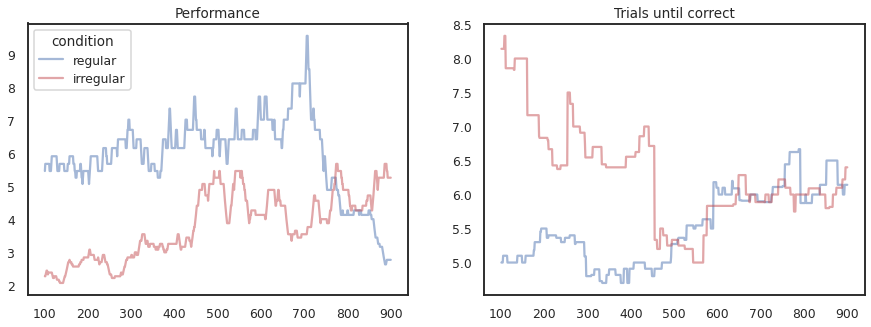

In [9]:
from stats import trials_until_correct, running_mean, performance

expl = jnp.sum(sequence['choices'] == 2, 0)/1000
print(expl/(1 - expl))
print(expl)

ws = 201
corr = outcomes[..., -1] - 2 == sequence['choices']

states =  outcomes[..., -1] - 2
tuc_data = trials_until_correct(corr.T, states.T, τ=3)
rolling_tuc = running_mean(tuc_data, ws=ws)
rolling_perf = performance(corr, ws=ws)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
trials = jnp.arange(101, 901)
axes[0].plot(trials, rolling_perf[:runs].T, 'b', alpha=0.5);
axes[0].plot(trials, rolling_perf[runs:].T, 'r', alpha=0.5);

axes[1].plot(trials, rolling_tuc[:runs].T, 'b', alpha=0.5);
axes[1].plot(trials, rolling_tuc[runs:].T, 'r', alpha=0.5);

axes[0].legend(['regular', 'irregular'], title='condition');

axes[0].set_title('Performance');
axes[1].set_title('Trials until correct');

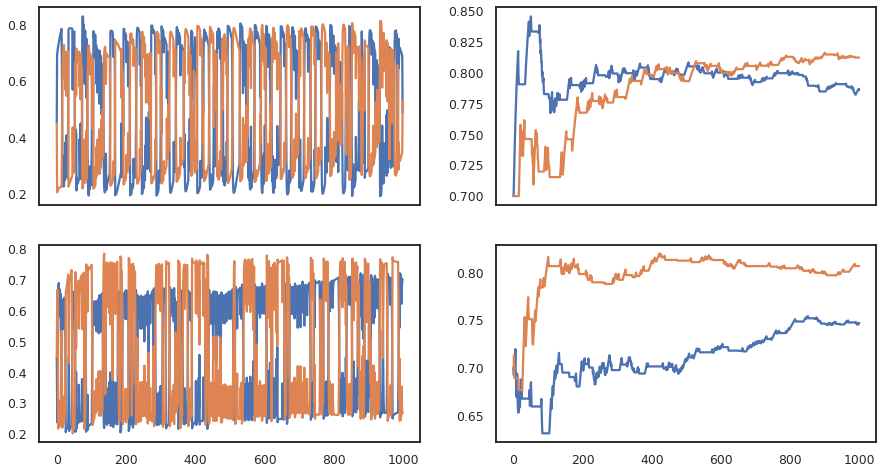

In [11]:
pars = sequence['beliefs'][1]
p_aco = pars/pars.sum(-1, keepdims=True)
marg = einsum('...cfm,...ac->...a', sequence['beliefs'][0], p_aco[..., 1])
marg_c = einsum('...cfm->...c', sequence['beliefs'][0])

fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
for cond in range(2):
    axes[cond, 0].plot(marg[:, cond, :-1])
    axes[cond, 1].plot(p_aco[:, cond, [0, 1], [0, 1], 1])

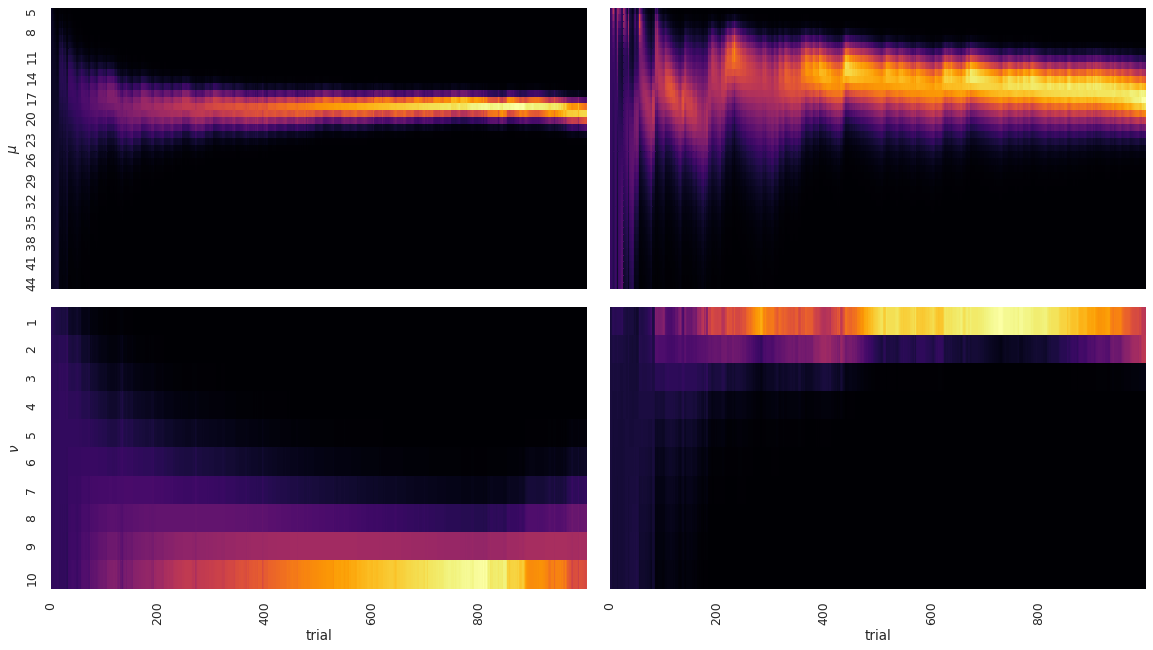

In [15]:
import numpy as np
marg = einsum('...cfm->...m', sequence['beliefs'][0]).reshape(outcomes.shape[:-1] + (len(mu), len(nu)))

fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')

for c in range(2):
    uniform_data = np.random.rand(10, 12)
    sns.heatmap(marg[:, c].sum(-1).T, ax=axes[0, c], cbar=False, cmap='inferno')
    sns.heatmap(marg[:, c].sum(-2).T, ax=axes[1, c], cbar=False, cmap='inferno')

fig.tight_layout()
axes[1, 0].set_xlabel('trial');
axes[1, 1].set_xlabel('trial');
axes[0, 0].set_ylabel(r'$\mu$');
axes[1, 0].set_ylabel(r'$\nu$');

axes[0, 0].set_yticklabels(mu.astype(int)[::3] + 1);
axes[1, 0].set_yticklabels(nu.astype(int));

trials = jnp.arange(0, marg.shape[0], 200);
axes[1, 0].set_xticks(trials);
axes[1, 0].set_xticklabels(trials);

In [20]:
from jax.scipy.special import digamma
vdiag = vmap(lambda v: jnp.diag(v, k=0))
voffd = vmap(lambda v: jnp.diag(v, k=1))
def log(x):
    return jnp.nan_to_num(jnp.log(x))

class Agent(object):
    def __init__(self, N, nu_max=1):
        self.N = N
        self.nu_max = nu_max
        
        self.__make_transition_matrices()
        self.__set_prior()
        
    def __make_transition_matrices(self):
        nu = jnp.arange(1, self.nu_max + 1)
        mu = jnp.arange(4., 45., 1.)
        p = mu[..., None]/(nu[None] + mu[..., None])
        
        j = jnp.tril(jnp.arange(1, self.nu_max + 1)[None].repeat(self.nu_max, 0))
        bnm = binom(nu[..., None], jnp.tril(j-1))
        p1 = p[..., None] ** jnp.tril((nu[..., None] - j + 1))
        p2 = (1 - p[..., None])**jnp.tril(j - 1)
        pi =  jnp.tril(bnm * p1 * p2)
        pi = jnp.concatenate([pi, 1 - pi.sum(-1, keepdims=True)], -1)
        
        # phase transition matrix for different models m, f_t| f_{t+1}
        p_ff = []
        for i in range(self.nu_max):
            vp = p[..., i:i + 1].repeat(i + 1, -1)
            tmp = jnp.concatenate([vdiag(vp) + voffd(1 - vp[..., :-1]), jnp.zeros((p.shape[0], i + 1, self.nu_max - i - 1))], -1)
            tmp = jnp.concatenate([tmp, 1 - tmp.sum(-1, keepdims=True)], -1)
            tmp = jnp.concatenate([tmp, jnp.ones((p.shape[0], self.nu_max - i - 1, self.nu_max + 1))/(self.nu_max + 1)], -2)
            tmp = jnp.concatenate([tmp, pi[:, i:i+1]], -2)
            p_ff.append(tmp)
        
        self.p_mff = jnp.stack(p_ff, -3).reshape(-1, self.nu_max + 1, self.nu_max + 1)
        
        # state transition matrix f_t, j_t| j_{t+1}
        p_fjj = jnp.zeros((self.nu_max + 1, 2, 2))
        p_fjj = ops.index_add(p_fjj, ops.index[-1, :, 1], 1.)
        p_fjj = ops.index_add(p_fjj, ops.index[:-1, :, 0], 1.)
        
        p_jcc = jnp.stack([jnp.eye(2), (jnp.ones((2, 2)) - jnp.eye(2))], 0)

        self.p_fcc = einsum('jcz,fj->fcz', p_jcc, p_fjj[:, 0])
        
    def __set_prior(self, a=6., b=32.):
        prior_mf = self.p_mff[:, -1]
        M = prior_mf.shape[0]
        prior_m = jnp.ones(M)/M
        prior_fm = (prior_mf * prior_m[:, None]).T
        prior_c = jnp.ones(2)/2

        pars = jnp.array([
            [[a, b, 1, 1], [b, a, 1, 1]],
            [[b, a, 1, 1], [a, b, 1, 1]],
            [[1, 1, 1000., 1], [1, 1, 1, 1000.]]
        ])[None].repeat(self.N, 0)
        
        probs = einsum('c,fm->cfm', prior_c, prior_fm)[None].repeat(self.N, 0)
        self.prior = (probs, pars)
        
    
    def __par_efe(self, p_c, params, omega, U):
        p_aco = params/params.sum(-1, keepdims=True)
        q_ao = einsum('...aco,...c->...ao', p_aco, p_c)
    
        KL_a =  - omega * jnp.sum(q_ao * U, -1) + jnp.sum(q_ao * log(q_ao), -1)
    
        H_ac = - (p_aco * digamma(params)).sum(-1) + digamma(params.sum(-1) + 1)
        H_a = einsum('...c,...ac->...a', p_c, H_ac)
    
        return KL_a + H_a
    
    def logits(self, beliefs, gamma, omega, U):
        p_cfm, params = beliefs

        # expected surprisal based action selection
        p_c = einsum('...cfm->...c', p_cfm)

        S_a = self.__par_efe(p_c, params, omega, U)

        return - gamma * ( S_a - S_a.min(-1, keepdims=True))

    def action_selection(self, rng_key, beliefs, gamma=1e3, omega=1., U=jnp.array([-1., 1., 0., 0.])):
        # sample choices
        return random.categorical(rng_key, logits(self, beliefs, gamma, omega, U))

    # parametric learning and inference
    def learning(self, observations, responses, mask, prior):
        p_cfm, params = prior
        obs = jnp.eye(4)[observations]

        p_aco = params/params.sum(-1, keepdims=True)

        p_c = einsum('nco,no->nc', p_aco[jnp.arange(self.N), responses], obs)
        
        m = jnp.expand_dims(mask, -1)
        p_c = m * p_c + (1 - m)/2.

        post = einsum('nc,ncfm->ncfm', p_c, p_cfm)
        norm = post.reshape(post.shape[:-3] + (-1,)).sum(-1)[..., None, None, None]
        post = post/norm

        resp = jnp.eye(3)[responses]
        post_c = post.reshape(post.shape[:-2] + (-1,)).sum(-1)

        params_new = params + einsum('na,nc,no,n->naco', resp, post_c, obs, mask)
        pred = einsum('fcz,mfg,ncfm->nzgm', self.p_fcc, self.p_mff, post)

        return (pred, params_new)
    
# implement simulator for POMDP
def estimate_beliefs(outcomes, choices, masks, nu_max=1):
    T, N = choices.shape
    assert outcomes.shape == (T, N)
    assert masks.shape == (T, N)
    agent = Agent(N, nu_max=nu_max)
    def sim_fn(carry, t):
        prior = carry
        posterior = agent.learning(outcomes[t], choices[t], masks[t], prior)
                
        return posterior, {'beliefs': prior}
    
    _, sequence = lax.scan(sim_fn, agent.prior, jnp.arange(T))
    
    sequence['beliefs'][0].block_until_ready()
    
    return sequence, agent

In [11]:
sequence1_sim, agent1_sim = estimate_beliefs(outcomes_sim, responses_sim, jnp.ones_like(responses_sim), nu_max=1)
sequence2_sim, agent2_sim = estimate_beliefs(outcomes_sim, responses_sim, jnp.ones_like(responses_sim), nu_max=10)

In [21]:
import numpyro as npyro
import numpyro.distributions as dist
from numpyro.handlers import mask as npyro_mask

def model(beliefs, agent, y=None, mask=True):
    T, N = beliefs[0].shape[:2]
    
    with npyro.plate('N', N):
        gamma = npyro.sample('gamma', dist.Gamma(20., 2.))
        prob = npyro.sample('prob', dist.Dirichlet(jnp.array([1., 5., 4.])))
        with npyro.plate('T', T):
            U = jnp.log(jnp.stack([prob[..., 0], prob[..., 1], prob[..., 2]/2, prob[..., 2]/2], -1))
            logits = agent.logits(beliefs, jnp.expand_dims(gamma, -1), 1., jnp.expand_dims(U, -2))
            obs = npyro.sample('obs', dist.CategoricalLogits(logits).mask(mask), obs=y)

# with npyro.handlers.seed(rng_seed=random.PRNGKey(0)):
#     model(sequence1_sim['beliefs'], agent1_sim, y=responses_sim)

In [22]:
from numpyro.infer import MCMC, NUTS
from numpyro.infer import log_likelihood
from jax.scipy.special import logsumexp

def log_pred_density(model, samples, *args, **kwargs):
    log_lk = log_likelihood(model, samples, *args, **kwargs)['obs'].sum(-2)
    n = log_lk.shape[0]
    _lpd = logsumexp(log_lk, 0) - jnp.log(n)
    p_waic = n * log_lk.var(0)/(n - 1)
    return {'lpd': _lpd, 'waic': _lpd - p_waic}

In [36]:
# fit simulated data
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

rng_key = random.PRNGKey(23478)
cutoff = 600
samples = []
for sequence, agent in zip([sequence1_sim['beliefs'], sequence2_sim['beliefs']], [agent1_sim, agent2_sim]):
    rng_key, _rng_key = random.split(rng_key)
    seq = (sequence[0][-cutoff:], sequence[1][-cutoff:])
    mcmc.run(_rng_key, seq, agent, y=responses_sim[-cutoff:], extra_fields=('potential_energy',))
    
    pe = mcmc.get_extra_fields()['potential_energy']
    print('Expected log joint density: {:.2f}'.format(jnp.mean(-pe)))
    
    mcmc.print_summary()
    samples.append(mcmc.get_samples())

sample: 100%|██████████| 1500/1500 [00:19<00:00, 78.11it/s, 7 steps of size 8.34e-02. acc. prob=0.93]  


Expected log joint density: -298.68

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.00      1.61      8.96      6.52     11.78    344.39      1.00
  gamma[1]      9.86      1.84      9.85      6.71     12.58    245.46      1.00
 prob[0,0]      0.20      0.02      0.20      0.16      0.23    310.63      1.00
 prob[0,1]      0.47      0.04      0.46      0.40      0.51    304.88      1.00
 prob[0,2]      0.34      0.02      0.34      0.32      0.36    332.51      1.00
 prob[1,0]      0.08      0.03      0.07      0.03      0.12    208.94      1.00
 prob[1,1]      0.64      0.07      0.64      0.53      0.75    191.62      1.00
 prob[1,2]      0.28      0.04      0.29      0.22      0.34    182.86      1.00

Number of divergences: 0


sample: 100%|██████████| 1500/1500 [00:19<00:00, 75.58it/s, 63 steps of size 7.32e-02. acc. prob=0.93]  


Expected log joint density: -179.52

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.91      1.91      9.73      6.69     12.64    273.26      1.01
  gamma[1]      9.78      1.78      9.66      7.03     12.66    380.83      1.00
 prob[0,0]      0.09      0.03      0.09      0.03      0.14    248.27      1.00
 prob[0,1]      0.62      0.07      0.62      0.50      0.72    235.56      1.00
 prob[0,2]      0.29      0.04      0.29      0.24      0.35    231.81      1.00
 prob[1,0]      0.07      0.03      0.07      0.03      0.12    362.48      1.00
 prob[1,1]      0.65      0.06      0.65      0.54      0.75    339.88      1.00
 prob[1,2]      0.28      0.04      0.28      0.22      0.34    318.62      1.00

Number of divergences: 0


In [37]:
#estimate WAIC/posterior predictive log likelihood
res_waic = []
for sequence, agent, sample in zip([sequence1_sim['beliefs'], sequence2_sim['beliefs']], [agent1_sim, agent2_sim], samples):
    seq = (sequence[0][-cutoff:], sequence[1][-cutoff:])
    res_waic.append(log_pred_density(model, sample, seq, agent, y=responses_sim[-cutoff:]))
print(res_waic[0]['waic'] - res_waic[1]['waic'])

[-119.405         0.38402557]


In [12]:
from stats import load_data

outcomes_data, responses_data, mask_data = load_data()

mask_data = jnp.array(mask_data)
responses_data = jnp.array(responses_data).astype(jnp.int32)
outcomes_data = jnp.array(outcomes_data).astype(jnp.int32)

In [13]:
sequences = {}
agents = {}
for nu_max in range(1, 11):
    sequences[nu_max], agents[nu_max] = estimate_beliefs(outcomes_data, responses_data, mask_data, nu_max=nu_max)

In [48]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

rng_key = random.PRNGKey(23478)
cutoff = 600
samples = {}
for nu_max in sequences:
    rng_key, _rng_key = random.split(rng_key)
    seq = (sequences[nu_max]['beliefs'][0][-cutoff:], 
           sequences[nu_max]['beliefs'][1][-cutoff:])
    mcmc.run(
        _rng_key, 
        seq, 
        agents[nu_max], 
        y=responses_data[-cutoff:], 
        mask=mask_data[-cutoff:].astype(bool), 
        extra_fields=('potential_energy',)
    )
    
    pe = mcmc.get_extra_fields()['potential_energy']
    print('Expected log joint density: {:.2f}'.format(jnp.mean(-pe)))
    
    mcmc.print_summary()
    samples[nu_max] = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [04:44<00:00,  5.27it/s, 63 steps of size 7.33e-02. acc. prob=0.85] 


Expected log joint density: -12552.67

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.25      1.89      9.11      5.99     12.12    736.00      1.00
  gamma[1]      7.26      1.48      7.19      4.71      9.34    584.14      1.00
  gamma[2]      9.49      1.88      9.31      6.37     12.40   1447.19      1.00
  gamma[3]     10.33      1.44     10.36      8.07     12.71    665.44      1.00
  gamma[4]      8.76      1.49      8.70      6.51     11.42    630.59      1.00
  gamma[5]      5.44      0.95      5.40      3.78      6.91    446.12      1.01
  gamma[6]      9.73      2.03      9.56      6.93     13.31   1502.31      1.00
  gamma[7]      9.58      1.97      9.48      6.45     12.85   1512.79      1.00
  gamma[8]      5.92      1.10      5.87      4.10      7.68    894.01      1.00
  gamma[9]      6.58      1.39      6.52      4.26      8.71    903.98      1.00
 gamma[10]      8.62      1.77      8.52      5.67     11.46   2020.26

sample: 100%|██████████| 1500/1500 [05:17<00:00,  4.73it/s, 127 steps of size 6.80e-02. acc. prob=0.88]


Expected log joint density: -12588.40

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.31      1.93      9.16      6.22     12.50    885.38      1.00
  gamma[1]      7.27      1.35      7.14      5.12      9.42    996.43      1.00
  gamma[2]      9.30      1.74      9.23      6.40     11.92   1312.00      1.00
  gamma[3]     10.56      1.51     10.49      7.97     12.92    973.37      1.00
  gamma[4]      8.26      1.42      8.22      5.77     10.43    740.35      1.00
  gamma[5]      5.27      0.89      5.21      3.81      6.56   1037.63      1.00
  gamma[6]      9.68      2.18      9.51      6.14     12.83   1661.59      1.00
  gamma[7]      9.61      2.12      9.41      6.13     12.94   1301.17      1.00
  gamma[8]      5.75      1.06      5.71      3.95      7.34    821.66      1.00
  gamma[9]      6.76      1.44      6.60      4.63      9.22    922.25      1.00
 gamma[10]      8.82      1.89      8.72      5.73     11.82   1164.33

sample: 100%|██████████| 1500/1500 [05:15<00:00,  4.76it/s, 127 steps of size 6.81e-02. acc. prob=0.89]


Expected log joint density: -12733.62

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.51      2.22      9.29      5.78     13.04    994.37      1.00
  gamma[1]      7.13      1.45      7.05      4.68      9.32    898.61      1.00
  gamma[2]      8.96      1.70      8.86      6.30     11.72   1553.62      1.00
  gamma[3]      9.74      1.44      9.71      7.13     11.88    834.04      1.00
  gamma[4]      7.62      1.27      7.54      5.66      9.86   1018.89      1.00
  gamma[5]      5.09      0.84      5.03      3.80      6.51   1031.31      1.00
  gamma[6]      9.78      2.10      9.60      6.05     12.73   1403.13      1.00
  gamma[7]      9.85      2.10      9.72      6.41     12.95   1240.77      1.00
  gamma[8]      5.52      1.02      5.49      3.90      7.16    933.00      1.00
  gamma[9]      6.96      1.44      6.85      4.80      9.34   1174.07      1.00
 gamma[10]      9.21      1.95      9.11      6.08     12.46   1357.81

sample: 100%|██████████| 1500/1500 [05:21<00:00,  4.67it/s, 127 steps of size 6.75e-02. acc. prob=0.89]


Expected log joint density: -12889.02

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.61      2.06      9.49      6.45     13.09   1631.66      1.00
  gamma[1]      6.94      1.47      6.88      4.19      8.96    983.83      1.00
  gamma[2]      8.73      1.66      8.62      5.86     11.18   1383.34      1.00
  gamma[3]      8.88      1.49      8.82      6.40     11.17   1032.80      1.00
  gamma[4]      7.04      1.20      7.00      5.30      9.28    942.28      1.00
  gamma[5]      4.90      0.87      4.85      3.43      6.29    815.28      1.00
  gamma[6]      9.79      2.11      9.64      6.10     12.90   1406.40      1.00
  gamma[7]      9.78      2.08      9.57      6.64     13.08   1260.12      1.00
  gamma[8]      5.29      0.98      5.28      3.59      6.70    958.30      1.00
  gamma[9]      7.00      1.52      6.93      4.41      9.34   1067.50      1.00
 gamma[10]      9.38      1.93      9.24      6.44     12.69   1090.90

sample: 100%|██████████| 1500/1500 [04:44<00:00,  5.26it/s, 127 steps of size 7.37e-02. acc. prob=0.88]


Expected log joint density: -13030.70

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.71      2.06      9.51      6.38     12.89   1007.04      1.01
  gamma[1]      6.98      1.36      6.83      4.80      9.11   1075.60      1.00
  gamma[2]      8.37      1.63      8.29      5.92     11.18   1394.84      1.00
  gamma[3]      8.13      1.31      8.04      5.95     10.16    949.91      1.00
  gamma[4]      6.62      1.18      6.53      4.70      8.52    554.85      1.00
  gamma[5]      4.73      0.81      4.71      3.42      6.02    745.19      1.00
  gamma[6]      9.82      2.05      9.66      6.46     13.13   1180.12      1.00
  gamma[7]      9.85      2.05      9.72      6.58     13.12   2075.74      1.00
  gamma[8]      5.16      0.93      5.09      3.63      6.65    650.12      1.00
  gamma[9]      7.03      1.49      6.93      4.54      9.32    753.79      1.00
 gamma[10]      9.61      2.06      9.43      6.30     12.63   1376.94

sample: 100%|██████████| 1500/1500 [04:52<00:00,  5.12it/s, 63 steps of size 7.25e-02. acc. prob=0.89] 


Expected log joint density: -13156.16

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.91      2.05      9.77      6.54     12.99   1044.01      1.00
  gamma[1]      6.92      1.42      6.83      4.69      9.18   1271.34      1.00
  gamma[2]      8.31      1.62      8.21      5.66     10.80   1311.92      1.00
  gamma[3]      7.41      1.25      7.37      5.46      9.52    647.68      1.00
  gamma[4]      6.32      1.20      6.28      4.24      8.11    973.62      1.00
  gamma[5]      4.55      0.80      4.48      3.31      5.86    561.92      1.01
  gamma[6]      9.83      2.16      9.69      6.21     13.10   1282.12      1.00
  gamma[7]      9.90      2.16      9.74      6.55     13.23   1489.87      1.00
  gamma[8]      5.11      0.92      5.08      3.54      6.54    998.87      1.00
  gamma[9]      7.09      1.48      6.96      4.88      9.63    850.04      1.00
 gamma[10]      9.79      2.00      9.62      6.63     13.26   1444.61

sample: 100%|██████████| 1500/1500 [03:56<00:00,  6.35it/s, 63 steps of size 8.10e-02. acc. prob=0.85] 


Expected log joint density: -13264.67

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.97      2.17      9.86      6.14     12.97   1051.75      1.00
  gamma[1]      6.83      1.39      6.76      4.51      9.05   1414.34      1.00
  gamma[2]      8.21      1.63      8.13      5.49     10.87   1692.23      1.00
  gamma[3]      6.88      1.16      6.84      5.13      8.92    735.76      1.00
  gamma[4]      6.02      1.09      5.99      4.29      7.80    923.26      1.00
  gamma[5]      4.51      0.71      4.46      3.43      5.77    768.84      1.00
  gamma[6]      9.96      2.03      9.86      6.60     13.11   1191.32      1.00
  gamma[7]      9.85      2.22      9.59      6.34     13.67   1601.88      1.00
  gamma[8]      5.00      0.90      4.93      3.49      6.39    937.65      1.00
  gamma[9]      7.11      1.54      7.00      4.72      9.71    850.10      1.00
 gamma[10]      9.99      2.10      9.88      6.59     13.34   1430.02

sample: 100%|██████████| 1500/1500 [05:20<00:00,  4.68it/s, 127 steps of size 6.62e-02. acc. prob=0.89]


Expected log joint density: -13362.23

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.98      2.09      9.81      6.34     13.02   1191.02      1.00
  gamma[1]      6.68      1.36      6.60      4.55      8.83    955.43      1.00
  gamma[2]      8.00      1.52      7.93      5.56     10.35   1732.47      1.00
  gamma[3]      6.46      1.05      6.42      4.85      8.24    926.69      1.00
  gamma[4]      5.75      1.08      5.72      3.88      7.39    349.02      1.00
  gamma[5]      4.38      0.73      4.36      3.13      5.50   1093.33      1.00
  gamma[6]      9.86      2.07      9.72      6.56     13.12   1400.74      1.00
  gamma[7]      9.78      2.20      9.65      6.18     13.44   1285.25      1.00
  gamma[8]      4.89      0.87      4.83      3.48      6.36   1032.10      1.00
  gamma[9]      7.17      1.48      7.11      4.93      9.37   1359.58      1.01
 gamma[10]     10.13      2.12      9.96      7.00     13.79   1335.68

sample: 100%|██████████| 1500/1500 [04:41<00:00,  5.33it/s, 127 steps of size 6.35e-02. acc. prob=0.90]


Expected log joint density: -13448.15

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.95      2.29      9.83      6.35     13.49    954.06      1.00
  gamma[1]      6.75      1.39      6.60      4.62      9.01   1125.59      1.00
  gamma[2]      7.98      1.48      7.87      5.45     10.16   1422.98      1.00
  gamma[3]      6.04      0.97      5.99      4.53      7.66   1574.07      1.00
  gamma[4]      5.61      1.01      5.59      3.92      7.21   1103.26      1.00
  gamma[5]      4.29      0.70      4.25      3.09      5.29   1096.55      1.00
  gamma[6]     10.02      2.18      9.92      6.36     13.34   1444.39      1.00
  gamma[7]      9.88      2.12      9.70      6.59     13.28   1349.98      1.00
  gamma[8]      4.77      0.90      4.73      3.28      6.14   1041.12      1.00
  gamma[9]      7.18      1.59      6.99      4.75      9.88   1043.24      1.00
 gamma[10]     10.09      2.08     10.02      6.84     13.30   1369.78

sample: 100%|██████████| 1500/1500 [05:32<00:00,  4.51it/s, 63 steps of size 6.32e-02. acc. prob=0.91] 


Expected log joint density: -13526.44

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.20      2.14     10.06      6.93     13.72   1464.67      1.00
  gamma[1]      6.71      1.36      6.61      4.60      8.92   1673.63      1.00
  gamma[2]      7.83      1.55      7.71      5.19     10.36   1799.76      1.00
  gamma[3]      5.81      0.96      5.78      4.26      7.30    932.71      1.00
  gamma[4]      5.49      1.00      5.42      3.86      7.06   1394.47      1.00
  gamma[5]      4.18      0.72      4.16      2.97      5.31    946.03      1.00
  gamma[6]     10.03      2.30      9.79      6.27     13.51   1653.61      1.00
  gamma[7]      9.90      2.06      9.79      6.54     12.92   1209.37      1.00
  gamma[8]      4.74      0.86      4.70      3.13      5.93   1076.49      1.00
  gamma[9]      7.16      1.61      7.11      4.39      9.53   1058.21      1.00
 gamma[10]     10.08      2.03      9.99      6.40     13.10   1463.87

In [ ]:
# compute predictive log likelihood
res_waic = []
for nu_max in sequences: 
    seq = (sequences[nu_max]['beliefs'][0][-cutoff:], sequences[nu_max]['beliefs'][1][-cutoff:])
    res_waic.append( log_pred_density(model, samples[nu_max], seq, agents[nu_max], y=responses_data[-cutoff:], mask=mask_data[-cutoff:])['waic'] )

<AxesSubplot:>

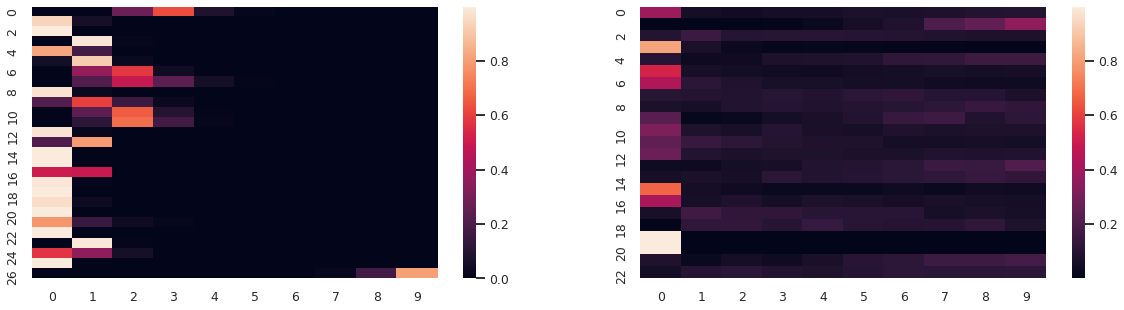

In [52]:
from jax import nn
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(nn.softmax(jnp.stack(res_waic, -1)[:27], -1), ax=axes[0])
sns.heatmap(nn.softmax(jnp.stack(res_waic, -1)[27:], -1), ax=axes[1])

In [23]:
from numpyro.distributions.distribution import Distribution
from numpyro.distributions import constraints
from numpyro.distributions.util import validate_sample

class CategoricalMixture(Distribution):
    arg_constraints = {'logits': constraints.real_vector}
    has_enumerate_support = False
    is_discrete = True

    def __init__(self, logits, weights, mask, validate_args=None):
        if jnp.ndim(logits) < 1:
            raise ValueError("`logits` parameter must be at least one-dimensional.")
        self.logits = logits
        self.weights = weights
        self.mask = mask
        super(CategoricalMixture, self).__init__(batch_shape=jnp.shape(weights)[:-1],
                                                validate_args=validate_args)
    def sample(self, key, sample_shape=()):
        raise NotImplementedError 

    @validate_sample
    def log_prob(self, value):
        mask = jnp.expand_dims(self.mask, -1)
        one_hot_value = jnp.eye(3)[value]
        logits = jnp.sum(jnp.expand_dims(one_hot_value, -1) * self.logits, -2) * mask
        log_z = logsumexp(self.logits, -2) * mask
        log_pmf = logsumexp(jnp.sum(logits - log_z, -3) + jnp.log(self.weights), -1)

        return log_pmf

    @property
    def support(self):
        return constraints.integer_interval(0, jnp.shape(self.logits)[-2] - 1)

In [24]:
def mixture_model(sequences, agents, mask, y=None):
    D = len(sequences)
    T, N = sequences[1]['beliefs'][0].shape[:2]
    
    tau = npyro.sample('tau', dist.HalfCauchy(1.))
    with npyro.plate('N', N):
        weights = npyro.sample('weights', dist.Dirichlet(tau * jnp.ones(D)))
        with npyro.plate('D', D):
            gamma = npyro.sample('gamma', dist.Gamma(20., 2.))
            prob = npyro.sample('prob', dist.Dirichlet(jnp.array([1., 5., 4.])))

        def vec_func(i, nu):
            U = jnp.log(jnp.stack([prob[i, :, 0], prob[i, :, 1], prob[i, :, 2]/2, prob[i, :, 2]/2], -1))
            res = agents[nu].logits(
                    sequences[nu]['beliefs'], 
                    jnp.expand_dims(gamma[i], -1), 
                    1., 
                    jnp.expand_dims(U, -2)
                  )
            return res
        logits = []
        for i, nu in enumerate(sequences):
            logits.append(vec_func(i, nu))

        obs = npyro.sample('obs', CategoricalMixture(logits, weights, mask), obs=y)

# with npyro.handlers.seed(rng_seed=random.PRNGKey(0)):
#     mixture_model(sequences, agents, mask_data, y=responses_data)

In [25]:
nuts_kernel = NUTS(mixture_model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000)

rng_key = random.PRNGKey(234786348)
cutoff = 600
seqs_cut = {}
for nu_max in sequences:
    rng_key, _rng_key = random.split(rng_key)
    seqs_cut[nu_max] = {'beliefs' :(sequences[nu_max]['beliefs'][0][-cutoff:],
                        sequences[nu_max]['beliefs'][1][-cutoff:])}
    
mcmc.run(
    _rng_key, 
    seqs_cut, 
    agents,
    mask_data[-cutoff:],
    y=responses_data[-cutoff:], 
    extra_fields=('potential_energy',)
)

pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(jnp.mean(-pe)))

mcmc.print_summary()
sample = mcmc.get_samples()

Exception: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([[[-0.7033054  -0.47175476 -0.        ]
  [-0.21759875 -0.         -0.05265158]
  [-0.         -0.6987022  -0.65153885]
  ...
  [-1.8429785  -1.487565   -0.        ]
  [-0.03948966 -0.         -0.09108281]
  [-0.3597215  -0.         -0.3772351 ]]

 [[-0.76330316 -0.64973587 -0.        ]
  [-0.1782569  -0.08730344 -0.        ]
  [-0.         -0.2992027  -0.18282089]
  ...
  [-1.8419564  -1.4853681  -0.        ]
  [-0.03961568 -0.         -0.09135436]
  [-0.3605111  -0.         -0.3781346 ]]

 [[-0.731059   -0.5259844  -0.        ]
  [-0.19031341 -0.         -0.01414236]
  [-0.         -0.6161661  -0.52285767]
  ...
  [-1.99934    -1.8792112  -0.        ]
  [-0.02140291 -0.         -0.04218084]
  [-0.12390733 -0.         -0.16076677]]

 ...

 [[-0.7168098  -0.5062812  -0.        ]
  [-0.20128258 -0.         -0.03573397]
  [-0.         -0.65709496 -0.65724784]
  ...
  [-1.6025221  -1.8437862  -0.        ]
  [-0.         -0.02161165 -0.07492917]
  [-0.         -0.2668863  -0.30240908]]

 [[-0.7111022  -0.49571267 -0.        ]
  [-0.20724443 -0.         -0.04456911]
  [-0.         -0.65824246 -0.6587337 ]
  ...
  [-1.506151   -1.7895727  -0.        ]
  [-0.         -0.02653998 -0.08760779]
  [-0.         -0.29659012 -0.33980873]]

 [[-0.76823443 -0.6745244  -0.        ]
  [-0.17305663 -0.09348579 -0.        ]
  [-0.         -0.27002108 -0.19312783]
  ...
  [-1.4817543  -1.7750046  -0.        ]
  [-0.         -0.0278604  -0.09126941]
  [-0.         -0.30286664 -0.34831122]]])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([[[-0.7033054 , -0.47175476, -0.        ],
                              [-0.21759875, -0.        , -0.05265158],
                              [-0.        , -0.6987022 , -0.65153885],
                              ...,
                              [-1.8429785 , -1.487565  , -0.        ],
                              [-0.03948966, -0.        , -0.09108281],
                              [-0.3597215 , -0.        , -0.3772351 ]],
                
                             [[-0.76330316, -0.64973587, -0.        ],
                              [-0.1782569 , -0.08730344, -0.        ],
                              [-0.        , -0.2992027 , -0.18282089],
                              ...,
                              [-1.8419564 , -1.4853681 , -0.        ],
                              [-0.03961568, -0.        , -0.09135436],
                              [-0.3605111 , -0.        , -0.3781346 ]],
                
                             [[-0.731059  , -0.5259844 , -0.        ],
                              [-0.19031341, -0.        , -0.01414236],
                              [-0.        , -0.6161661 , -0.52285767],
                              ...,
                              [-1.99934   , -1.8792112 , -0.        ],
                              [-0.02140291, -0.        , -0.04218084],
                              [-0.12390733, -0.        , -0.16076677]],
                
                             ...,
                
                             [[-0.7168098 , -0.5062812 , -0.        ],
                              [-0.20128258, -0.        , -0.03573397],
                              [-0.        , -0.65709496, -0.65724784],
                              ...,
                              [-1.6025221 , -1.8437862 , -0.        ],
                              [-0.        , -0.02161165, -0.07492917],
                              [-0.        , -0.2668863 , -0.30240908]],
                
                             [[-0.7111022 , -0.49571267, -0.        ],
                              [-0.20724443, -0.        , -0.04456911],
                              [-0.        , -0.65824246, -0.6587337 ],
                              ...,
                              [-1.506151  , -1.7895727 , -0.        ],
                              [-0.        , -0.02653998, -0.08760779],
                              [-0.        , -0.29659012, -0.33980873]],
                
                             [[-0.76823443, -0.6745244 , -0.        ],
                              [-0.17305663, -0.09348579, -0.        ],
                              [-0.        , -0.27002108, -0.19312783],
                              ...,
                              [-1.4817543 , -1.7750046 , -0.        ],
                              [-0.        , -0.0278604 , -0.09126941],
                              [-0.        , -0.30286664, -0.34831122]]], dtype=float32)
       tangent = Traced<ShapedArray(float32[600,50,3]):JaxprTrace(level=1/0)>.

This error can occur when a JAX Tracer object is passed to a raw numpy function, or a method on a numpy.ndarray object. You might want to check that you are using `jnp` together with `import jax.numpy as jnp` rather than using `np` via `import numpy as np`. If this error arises on a line that involves array indexing, like `x[idx]`, it may be that the array being indexed `x` is a raw numpy.ndarray while the indices `idx` are a JAX Tracer instance; in that case, you can instead write `jax.device_put(x)[idx]`.

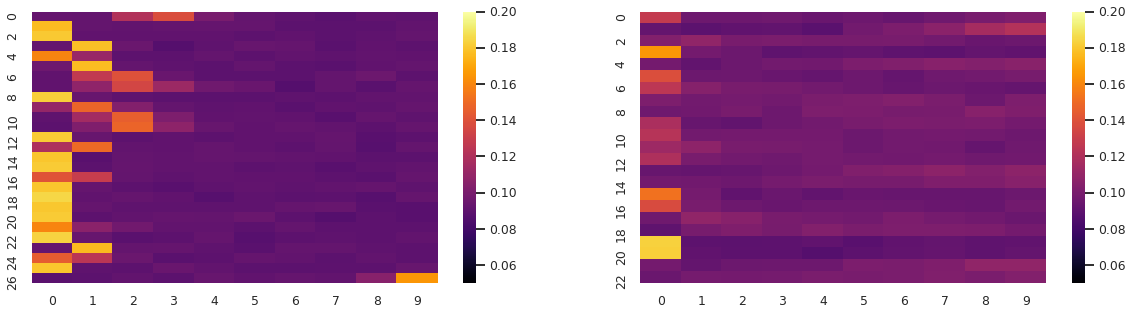

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(sample['weights'].mean(0)[:27], ax=axes[0], cmap='inferno', vmin=.05, vmax=.2);
sns.heatmap(sample['weights'].mean(0)[27:], ax=axes[1], cmap='inferno', vmin=.05, vmax=.2);